In [1]:
import numpy as np

import warnings
warnings.filterwarnings('ignore')

from tqdm import tqdm

import torch
from torch.utils.data import DataLoader

import pytorch_lightning as pl

from deeptime.models.multiclass.linear import LinearClassifier
from deeptime.data import BaseDataset
from deeptime.utils.viz import plot_distributions, visualize_activations, visualize_gradients, visualize_weight_distribution

from sktime.datasets import load_UCR_UEA_dataset

In [2]:
dataset = 'ECG5000'
NUM_CLASSES = 5

x_train, y_train = load_UCR_UEA_dataset(name=dataset, split='train')
y_train = np.array(y_train, dtype=np.int32)
y_train = y_train - 1
y_train = np.eye(NUM_CLASSES)[y_train]

sequence_length = x_train.values[0][0].shape[0]

x_test, y_test = load_UCR_UEA_dataset(name=dataset, split='test')
y_test = np.array(y_test, dtype='int32') # Fixing the labels type
y_test = y_test - 1
y_test = np.eye(NUM_CLASSES)[y_test]

x_train_transformed = []
for val in x_train.values:
    x_train_transformed.append(val[0].tolist())
x_train = np.array(x_train_transformed)

x_test_transformed = []
for val in x_test.values:
    x_test_transformed.append(val[0].tolist())
x_test = np.array(x_test_transformed)

full_train_dataset = BaseDataset(x=x_train, y=y_train)
train_loader = DataLoader(full_train_dataset, batch_size=32)

test_dataset = BaseDataset(x=x_test, y=y_test)
test_loader = DataLoader(test_dataset, batch_size=32)

In [17]:
x_train, y_train = load_UCR_UEA_dataset(name=dataset, split='train')
y_train = np.array(y_train, dtype=np.int32)
np.unique(y_train).shape[0]

5

In [3]:
model = LinearClassifier(
    in_features=sequence_length,
    num_classes=NUM_CLASSES,
    activation='sinelu'
)
model

LinearClassifier(
  (layers): Sequential(
    (0): Linear(in_features=140, out_features=64, bias=True)
    (1): SineLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): SineLU()
    (4): Linear(in_features=64, out_features=5, bias=True)
    (5): SineLU()
    (6): Softmax(dim=None)
  )
  (criterion): CrossEntropyLoss()
)

In [4]:
def const_init(model, fill=0.0):
    for name, param in model.named_parameters():
        param.data.fill_(fill)

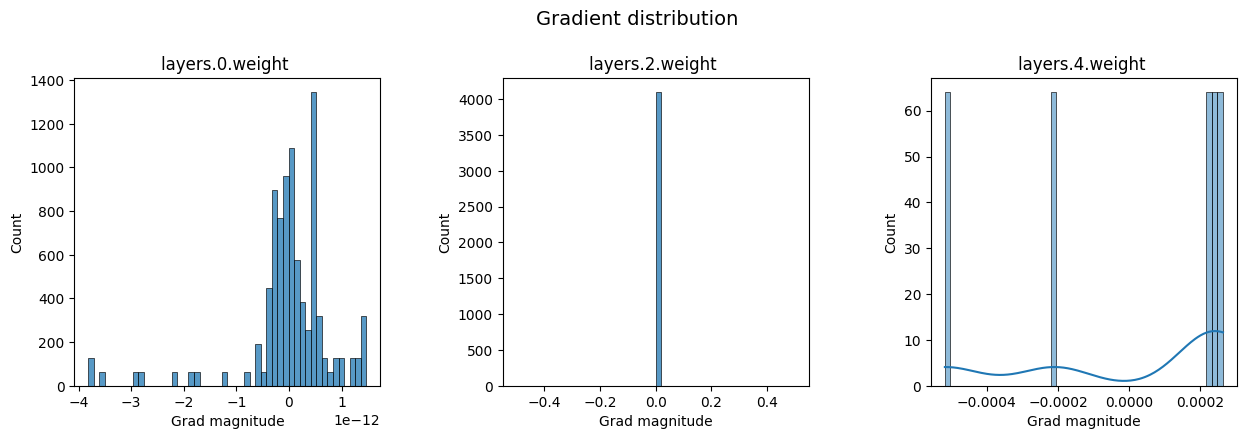

In [5]:
const_init(model, fill=0.005)

visualize_gradients(model, train_dataset=full_train_dataset)

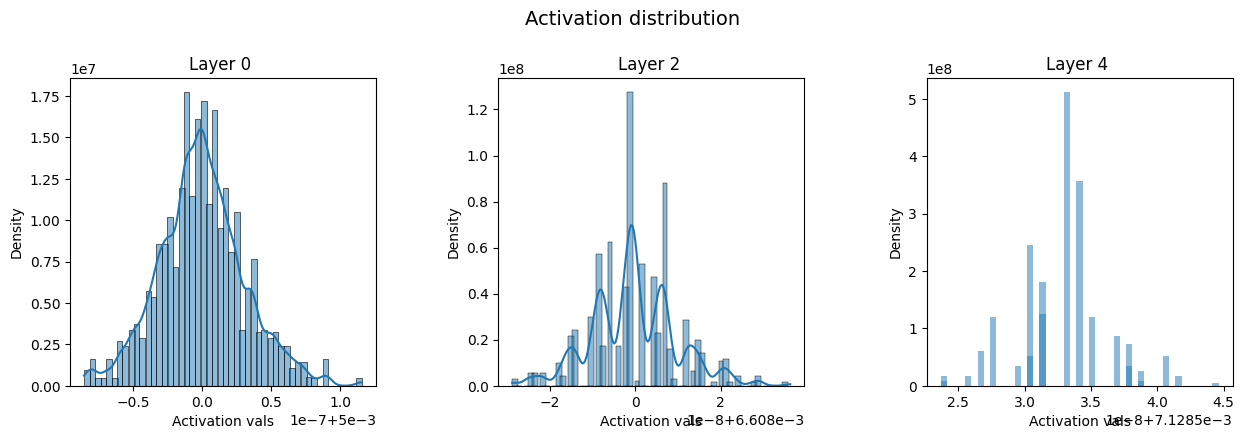

Layer 0 - Variance: 9.707087572784928e-16
Layer 2 - Variance: 1.0194536505084056e-16
Layer 4 - Variance: 1.0940901240918408e-17


In [6]:
visualize_activations(model, train_dataset=full_train_dataset, print_variance=True)

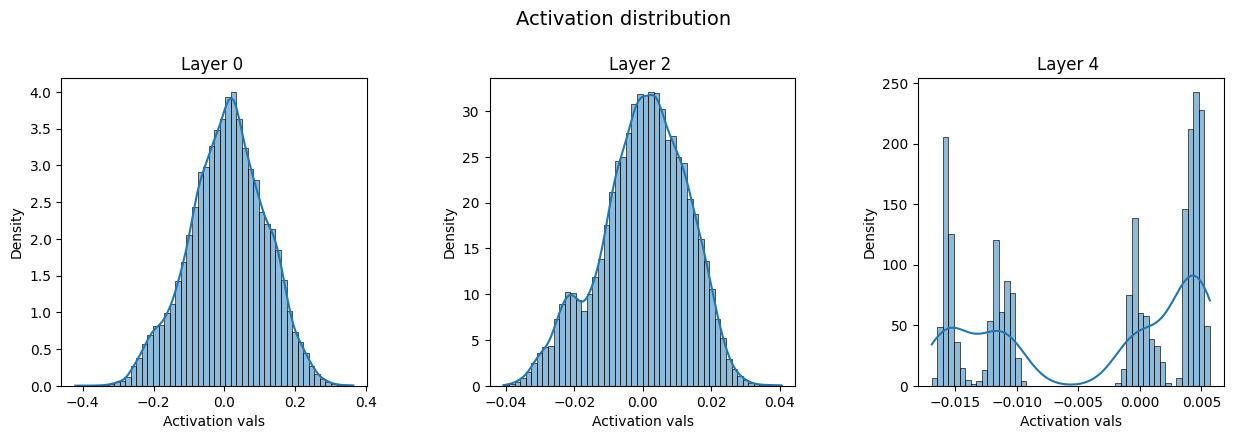

Layer 0 - Variance: 0.011475645005702972
Layer 2 - Variance: 0.00016172950563486665
Layer 4 - Variance: 6.932434189366177e-05


In [8]:
def var_init(model, std=0.01):
    for name, param in model.named_parameters():
        param.data.normal_(mean=0.0, std=std)
        
var_init(model, std=0.01)
visualize_activations(model, full_train_dataset, print_variance=True)

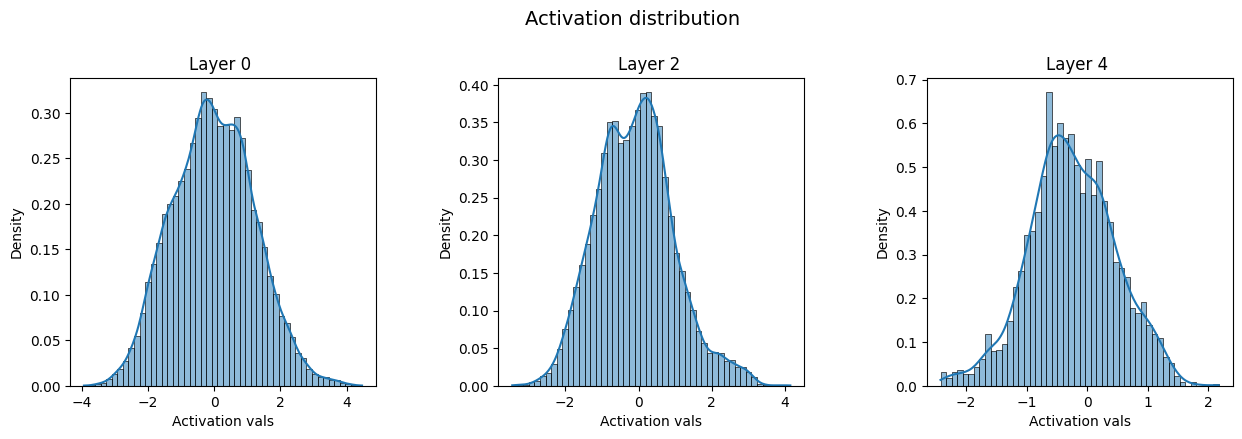

Layer 0 - Variance: 1.5172224044799805
Layer 2 - Variance: 1.1112124919891357
Layer 4 - Variance: 0.5045596957206726


In [10]:
var_init(model, std=0.1)
visualize_activations(model, full_train_dataset, print_variance=True)

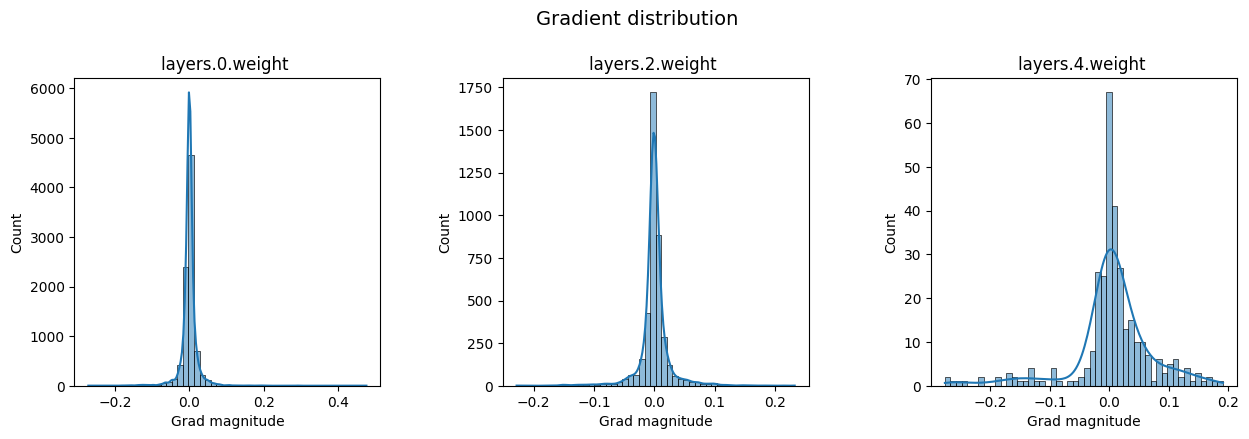

layers.0.weight - Variance: 0.0006439713761210442
layers.2.weight - Variance: 0.0006645862013101578
layers.4.weight - Variance: 0.004708113148808479


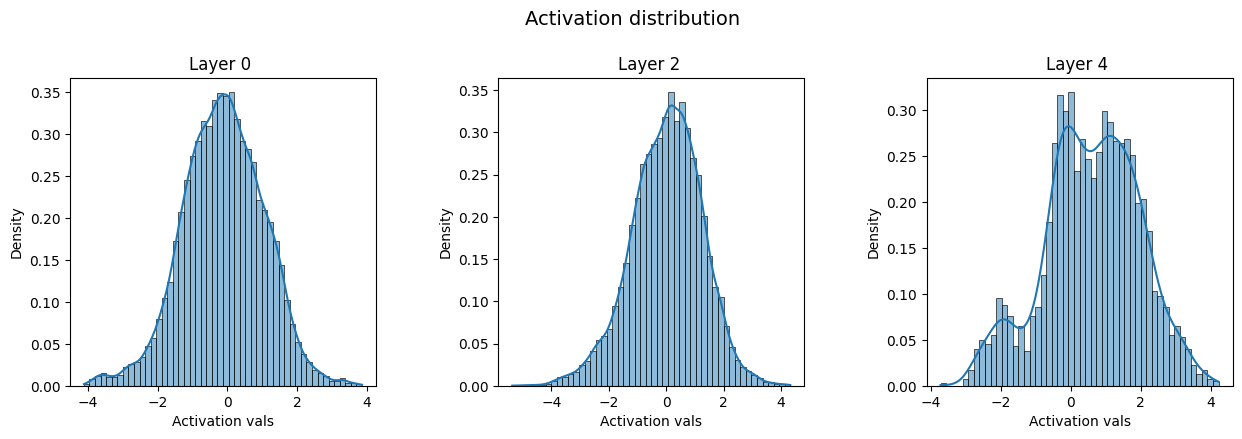

Layer 0 - Variance: 1.3341549634933472
Layer 2 - Variance: 1.505085825920105
Layer 4 - Variance: 1.8388274908065796


In [13]:
import math

def xavier_init(model):
    for name, param in model.named_parameters():
        if name.endswith(".bias"):
            param.data.fill_(0)
        else:
            bound = math.sqrt(6) / math.sqrt(param.shape[0] + param.shape[1])
            param.data.uniform_(-bound, bound)


xavier_init(model)
visualize_gradients(model, full_train_dataset, print_variance=True)
visualize_activations(model, full_train_dataset, print_variance=True)